In [1]:
%matplotlib inline

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# pytorch
import torch
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from collections import OrderedDict

# others
import numpy as np
import pandas as pd

The ODE to solve:
\begin{equation*}
y'=sin\left(x\right)\left(2y-4\right)
\end{equation*}

The solution:
\begin{equation*}
y=e^{-2\cos \left(x\right)+c_1}+2
\end{equation*}

In [2]:
def objective(x):
    return torch.exp(-2 * torch.cos(x) + 1) + 2

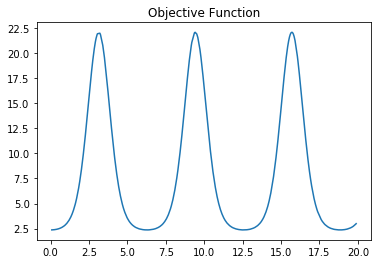

In [3]:
x = torch.empty(500).uniform_(0, 20)
y = objective(x)
sns.lineplot(x=x, y=y)
plt.title('Objective Function')
plt.show()

In [4]:
# Multi-layer Perceptron
class DNN(torch.nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth
    ):
        super(DNN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', torch.nn.Tanh()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, torch.nn.Tanh()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
device = torch.device('cuda')

trainX = x.view(-1, 1).to(device)
trainY = y.view(-1, 1).to(device)

In [6]:
D_in  = trainX.shape[1]
D_out = trainY.shape[1]
H = 50
Depth = 5
NUMEPOCHS = 5000
Batch_size = int(trainX.shape[0] / 10)

# get training data loader
data_train_loader = DataLoader(
    list(zip(trainX, trainY)), 
    batch_size=Batch_size, 
    shuffle=True
)

print('input dimension =', D_in)
print('output dimension =', D_out)
print('hidden layer size =', H)
print('depth =', Depth)
print('training epochs =', NUMEPOCHS)
print('batch size =', Batch_size)

print('----------------------------------')

input dimension = 1
output dimension = 1
hidden layer size = 50
depth = 5
training epochs = 5000
batch size = 50
----------------------------------


In [7]:
%%time

# Compile model
model = DNN(D_in, H, D_out, Depth).to(device)

# Loss Function
criterion = torch.nn.MSELoss()

# Optimizer
optimizer = optim.Adamax(model.parameters())

CPU times: user 5.83 ms, sys: 654 µs, total: 6.48 ms
Wall time: 6.08 ms


In [8]:
def analytic_loss(inputs, model, res=1e-4):
    outputs = model(inputs)
    grad = (torch.sin(inputs.detach()) * (2 * outputs.detach() - 4)).detach() # defined by true derivatives
#     grad = torch.sin(inputs) * (2 * outputs - 4) # defined by true derivatives
    
    left = inputs - res
    right = inputs + res
    
    y_left = outputs - grad * res
    y_right = outputs + grad * res
    out_left = model(left)
    out_right = model(right)
    
    # mse over integration
    loss_left = criterion(out_left, y_left)
    loss_right = criterion(out_right, y_right)
    
    return (loss_left + loss_right) / res

In [9]:
%%time

from tqdm import tqdm

# For Supervising Losses
mse_losses = np.zeros(NUMEPOCHS)
analytic_losses = np.zeros(NUMEPOCHS)

# initial resolution
res = 1e-3

print('epoch', '\t', 'mse_losses', '\t\t', 'analytic_losses', '\t', 'step')

# Train the model
for epoch in range(NUMEPOCHS):
    for batchX, batchY in data_train_loader: 
        # Forward pass
        loss = criterion(model(batchX), batchY)
        
        sample = torch.empty(2000).uniform_(20, 50).view(-1, 1).to(device)
        loss_analytic = analytic_loss(sample, model, res=res) / res
        loss += loss_analytic
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#     # update step
#     res *= 0.999
    
    # record the loss history
    mse_losses[epoch] = criterion(model(trainX), trainY).item()
    analytic_losses[epoch] = loss_analytic.item()
    
    if epoch % 100 == 0:
        print(epoch, '\t', mse_losses[epoch], '\t', analytic_losses[epoch], '\t', res)

epoch 	 mse_losses 		 analytic_losses 	 step
0 	 82.27132415771484 	 1.1480631828308105 	 0.001
100 	 41.63059616088867 	 132.531982421875 	 0.001
200 	 30.81393051147461 	 182.64456176757812 	 0.001
300 	 19.751237869262695 	 234.69017028808594 	 0.001
400 	 1.270410180091858 	 28.43326759338379 	 0.001
500 	 0.08416546136140823 	 0.5365499258041382 	 0.001
600 	 0.036762382835149765 	 0.3598344922065735 	 0.001
700 	 0.1381811499595642 	 107.92190551757812 	 0.001
800 	 0.022761499509215355 	 0.23175102472305298 	 0.001
900 	 0.03486386686563492 	 1.0848523378372192 	 0.001
1000 	 0.9803547859191895 	 14.334480285644531 	 0.001
1100 	 0.8177295923233032 	 3.35746169090271 	 0.001
1200 	 0.6034737825393677 	 38.98472213745117 	 0.001
1300 	 0.039481021463871 	 0.30149567127227783 	 0.001
1400 	 0.27258574962615967 	 0.42208993434906006 	 0.001
1500 	 1.9126821756362915 	 8.790092468261719 	 0.001
1600 	 0.1439703106880188 	 4.067096710205078 	 0.001
1700 	 0.04487025737762451 	 0.9159

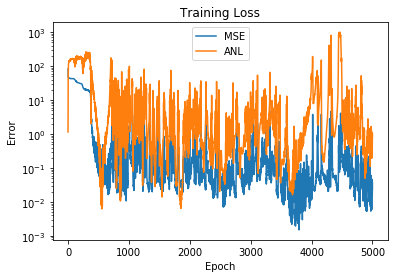

In [10]:
sns.lineplot(data=mse_losses, label="MSE")
sns.lineplot(data=analytic_losses, label="ANL")
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.yscale('log')
plt.title('Training Loss')
plt.show()

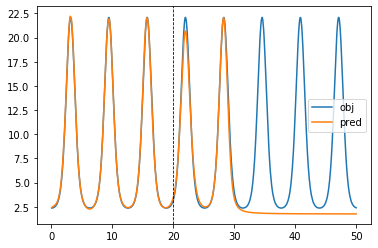

In [11]:
testX = torch.empty(2000).uniform_(0, 50).view(-1, 1).to(device)

test = testX.detach().cpu().numpy().ravel()
pred = model(testX).detach().cpu().numpy().ravel()
obj = objective(testX).detach().cpu().numpy().ravel()

sns.lineplot(x=test, y=obj, label='obj')
sns.lineplot(x=test, y=pred, label='pred')

plt.axvline(x=20, color='k', linestyle='--', linewidth=0.8)

plt.show()

In [12]:
testX.requires_grad = True
outputs = model(testX)

dy_dx = torch.autograd.grad(
    inputs=testX, 
    outputs=outputs, 
    grad_outputs=torch.ones_like(outputs)
)[0].cpu().numpy()
dy_dx

array([[-1.3648694e-03],
       [-7.4485166e-04],
       [-2.2179960e-01],
       ...,
       [-1.1988251e-03],
       [-5.6985747e-03],
       [ 3.7213712e+00]], dtype=float32)

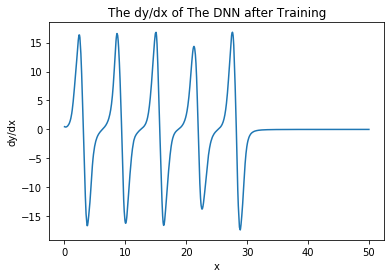

In [13]:
sns.lineplot(
    x=testX.detach().cpu().numpy().ravel(), 
    y=dy_dx.ravel()
)
plt.title("The dy/dx of The DNN after Training")
plt.xlabel("x")
plt.ylabel("dy/dx")
plt.show()